In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from mpld3 import display

import numpy as np
import math
import os
import numpy as np
import pickle
import quandl
from datetime import datetime

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

plt.style.use('ggplot')
%matplotlib inline

ImportError: No module named 'keras'

In [3]:
def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

In [4]:
df = get_quandl_data('BCHARTS/KRAKENUSD')
df.head()

Loaded BCHARTS/KRAKENUSD from cache


,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


In [5]:
btc_trace = go.Scatter(x=df.index, y=df['Weighted Price'])
py.iplot([btc_trace])

NameError: name 'go' is not defined

In [6]:
# Pull pricing data for 3 more BTC exchanges
exchanges = ['COINBASE','BITSTAMP','ITBIT']

exchange_data = {}

exchange_data['KRAKEN'] = df

for exchange in exchanges:
    exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = get_quandl_data(exchange_code)
    exchange_data[exchange] = btc_exchange_df


Loaded BCHARTS/COINBASEUSD from cache
Loaded BCHARTS/BITSTAMPUSD from cache
Loaded BCHARTS/ITBITUSD from cache


In [7]:
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

In [8]:
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')

In [9]:
btc_usd_datasets.tail()


,BITSTAMP,COINBASE,ITBIT,KRAKEN
Date,,,,
2017-10-28,5736.038974,5774.246928,5727.183448,5751.871922
2017-10-29,5990.189374,6033.384476,6050.093020,5982.502457
2017-10-30,6124.204959,6112.901139,6126.593569,6117.285003
2017-10-31,6284.179318,6319.249739,6284.178017,6299.346958
2017-11-01,6527.618676,6543.506240,6537.107050,6537.068590


In [10]:
def df_scatter(df, title, seperate_y_axis=False, y_axis_label='', scale='linear', initial_hide=False):
    '''Generate a scatter plot of the entire dataframe'''
    label_arr = list(df)
    series_arr = list(map(lambda col: df[col], label_arr))
    
    layout = go.Layout(
        title=title,
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title=y_axis_label,
            showticklabels= not seperate_y_axis,
            type=scale
        )
    )
    
    y_axis_config = dict(
        overlaying='y',
        showticklabels=False,
        type=scale )
    
    visibility = 'visible'
    if initial_hide:
        visibility = 'legendonly'
        
    # Form Trace For Each Series
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index],
            visible=visibility
        )
        
        # Add seperate axis for the series
        if seperate_y_axis:
            trace['yaxis'] = 'y{}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config    
        trace_arr.append(trace)

    fig = go.Figure(data=trace_arr, layout=layout)
    py.iplot(fig)

In [11]:
labels = list(btc_usd_datasets)
series_arr = list(map(lambda col: btc_usd_datasets[col], labels))
series_arr

[Date
 2011-09-13       5.929231
 2011-09-14       5.590798
 2011-09-15       5.094272
 2011-09-16       4.854515
 2011-09-17       4.870000
 2011-09-18       4.839576
 2011-09-19       4.900000
 2011-09-20       5.388054
 2011-09-21       5.706075
 2011-09-22       5.696960
 2011-09-23       5.707099
 2011-09-24       5.722494
 2011-09-25       6.050000
 2011-09-26       5.983073
 2011-09-27       4.895402
 2011-09-28       4.862498
 2011-09-29       4.816345
 2011-09-30       0.000000
 2011-10-01       0.000000
 2011-10-02       0.000000
 2011-10-03       4.847772
 2011-10-04       4.924737
 2011-10-05       5.029419
 2011-10-06       4.908846
 2011-10-07       4.687629
 2011-10-08       4.455536
 2011-10-09       3.890000
 2011-10-10       4.498302
 2011-10-11       3.998965
 2011-10-12       3.943964
                  ...     
 2017-10-03    4295.104231
 2017-10-04    4233.863791
 2017-10-05    4265.134362
 2017-10-06    4363.297357
 2017-10-07    4373.286986
 2017-10-08    4511.21

In [12]:
btc_usd_datasets.replace(0, np.nan, inplace=True)
df_scatter(btc_usd_datasets, 'Bitcoin Price (USD) By Exchange')

NameError: name 'go' is not defined

In [13]:
btc_usd_datasets['avg_btc_price_usd'] = btc_usd_datasets.mean(axis=1)
btc_trace = go.Scatter(x=btc_usd_datasets.index, y=btc_usd_datasets['avg_btc_price_usd'])
py.iplot([btc_trace])

NameError: name 'go' is not defined

# Prediction

In [56]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

scaler = MinMaxScaler(feature_range=(0,1))
scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

In [57]:
df = btc_usd_datasets['avg_btc_price_usd']
df = df.dropna(how='all') 

In [58]:
ds = scaler.fit_transform(df)[-1000:]
ds = ds.reshape(len(ds), 1)
ds.shape

/Users/nicolasfeller/anaconda/envs/ztdl/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/nicolasfeller/anaconda/envs/ztdl/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


(1000, 1)

In [41]:
def train_test_split(data, test_size=0.2):
    train_set_size = int(len(data) * (1-test_size))
    train_set = data[:train_set_size]
    test_set = data[-(len(data)-train_set_size):]
    return train_set, test_set

In [66]:
train, test = train_test_split(ds)
len(ds), len(train), len(test)

(1000, 800, 200)

In [43]:
def create_dataset(dataset, lookback=1):
    dataX, dataY = [], []
    for i in range(0, len(dataset) - lookback):
        dataY.append(dataset[i+lookback, 0])
        dataX.append(dataset[i])
    return np.array(dataX), np.array(dataY)

look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [44]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((799, 1), (799,), (199, 1), (199,))

In [60]:
y_test

array([ 0.18106328,  0.18371001,  0.1835957 ,  0.18707663,  0.19009562,
        0.18886258,  0.18958634,  0.1905509 ,  0.19394202,  0.19800154,
        0.20218561,  0.20274543,  0.20455848,  0.20480814,  0.21451647,
        0.22102663,  0.22632436,  0.23743124,  0.23861616,  0.23843309,
        0.2380634 ,  0.24588763,  0.26229407,  0.26802926,  0.28065688,
        0.26695609,  0.26013376,  0.27360428,  0.26570416,  0.26467143,
        0.27615404,  0.28241627,  0.29520024,  0.30447192,  0.31074531,
        0.32518132,  0.33606851,  0.3612433 ,  0.38592917,  0.3583032 ,
        0.31542145,  0.33528379,  0.34364355,  0.34454878,  0.34391348,
        0.36592866,  0.37089021,  0.38591336,  0.3851117 ,  0.39847351,
        0.43065878,  0.42610336,  0.41997404,  0.43217195,  0.43701556,
        0.44403352,  0.42557877,  0.41436274,  0.39796095,  0.35469278,
        0.37367683,  0.39180912,  0.39123119,  0.39059559,  0.40870288,
        0.41108787,  0.40894065,  0.41375075,  0.39941307,  0.38

In [45]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_train.shape, X_test.shape

((799, 1, 1), (199, 1, 1))

In [46]:
model = Sequential()

# 8 units, 
model.add(LSTM(8, input_shape=(1, look_back), dropout=0.2))

# Get a single value
model.add(Dense(1, activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=23, batch_size=1, verbose=2)

Epoch 1/23
 - 5s - loss: 0.0012
Epoch 2/23
 - 4s - loss: 9.8630e-04
Epoch 3/23
 - 4s - loss: 7.8124e-04
Epoch 4/23
 - 4s - loss: 9.2113e-04
Epoch 5/23
 - 4s - loss: 7.7963e-04
Epoch 6/23
 - 4s - loss: 9.1996e-04
Epoch 7/23
 - 4s - loss: 7.5646e-04
Epoch 8/23
 - 4s - loss: 8.5005e-04
Epoch 9/23
 - 4s - loss: 6.7933e-04
Epoch 10/23
 - 4s - loss: 8.0417e-04
Epoch 11/23
 - 4s - loss: 8.7000e-04
Epoch 12/23
 - 4s - loss: 6.9769e-04
Epoch 13/23
 - 4s - loss: 6.5320e-04
Epoch 14/23
 - 4s - loss: 6.5674e-04
Epoch 15/23
 - 4s - loss: 5.2216e-04
Epoch 16/23
 - 4s - loss: 6.6438e-04
Epoch 17/23
 - 4s - loss: 6.3732e-04
Epoch 18/23
 - 4s - loss: 5.4070e-04
Epoch 19/23
 - 4s - loss: 5.8244e-04
Epoch 20/23
 - 4s - loss: 5.4300e-04
Epoch 21/23
 - 4s - loss: 5.1438e-04
Epoch 22/23
 - 4s - loss: 5.6375e-04
Epoch 23/23
 - 4s - loss: 5.4004e-04


In [67]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])
# calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))

In [68]:
y_test

array([ 0.18106328,  0.18371001,  0.1835957 ,  0.18707663,  0.19009562,
        0.18886258,  0.18958634,  0.1905509 ,  0.19394202,  0.19800154,
        0.20218561,  0.20274543,  0.20455848,  0.20480814,  0.21451647,
        0.22102663,  0.22632436,  0.23743124,  0.23861616,  0.23843309,
        0.2380634 ,  0.24588763,  0.26229407,  0.26802926,  0.28065688,
        0.26695609,  0.26013376,  0.27360428,  0.26570416,  0.26467143,
        0.27615404,  0.28241627,  0.29520024,  0.30447192,  0.31074531,
        0.32518132,  0.33606851,  0.3612433 ,  0.38592917,  0.3583032 ,
        0.31542145,  0.33528379,  0.34364355,  0.34454878,  0.34391348,
        0.36592866,  0.37089021,  0.38591336,  0.3851117 ,  0.39847351,
        0.43065878,  0.42610336,  0.41997404,  0.43217195,  0.43701556,
        0.44403352,  0.42557877,  0.41436274,  0.39796095,  0.35469278,
        0.37367683,  0.39180912,  0.39123119,  0.39059559,  0.40870288,
        0.41108787,  0.40894065,  0.41375075,  0.39941307,  0.38

In [71]:
X_test.shape

(199, 1, 1)

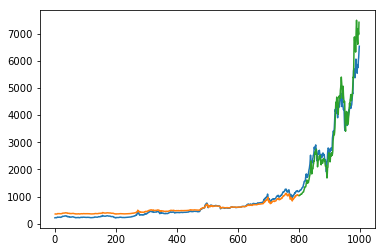

In [70]:

trainPredictPlot = np.empty_like(ds)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(ds)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(ds)-1, :] = testPredict[:197]

# # plot baseline and predictions
plt.plot(scaler.inverse_transform(ds))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [202]:
# btc_usd_datasets['avg_btc_price_usd'] = btc_usd_datasets.mean(axis=1)
# btc_trace = go.Scatter(x=btc_usd_datasets.index, y=btc_usd_datasets['avg_btc_price_usd'])
# py.iplot([btc_trace])

In [52]:
test_trace = go.Scatter(x=df.index[-1000:], y=testPredictPlot.ravel(), name="Prediction")
train_trace = go.Scatter(x=df.index[-1000:], y=trainPredictPlot.ravel(), name="Traning")
actual_trace = go.Scatter(x=df.index[-1000:], y=scaler.inverse_transform(ds).ravel(), name="Actual")

# figure_or_data -- a plotly.graph_objs.Figure or plotly.graph_objs.Data or
#                   dict or list that describes a Plotly graph.
#                   See https://plot.ly/python/ for examples of
#                   graph descriptions.

layout = go.Layout(
        title="Bitcoin Actual Price, Training Data and Model Prediction",
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title="Bitcoin Price",
        )
    )
                
fig = go.Figure(data=[test_trace, train_trace,actual_trace], layout=layout)

py.iplot(fig)

NameError: name 'go' is not defined

In [159]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [13]:
from datetime import datetime
import pandas as pd

base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2015-01-01', '%Y-%m-%d') # get data from the start of 2015
end_date = datetime.now() # up until today
pediod = 86400 # pull daily data (86,400 seconds per day)

def get_crypto_data(poloniex_pair):
    poloniex_pair = "BTC_{}".format(poloniex_pair)
    '''Retrieve cryptocurrency data from poloniex'''
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), pediod)
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

def get_json_data(json_url, cache_path):
#     '''Download and cache JSON data, return as a dataframe.'''
#     try:        
#         f = open(cache_path, 'rb')
#         df = pickle.load(f)   
#         print('Loaded {} from cache'.format(json_url))
#     except (OSError, IOError) as e:
    print('Downloading {}'.format(json_url))
    df = pd.read_json(json_url)
    df.to_pickle(cache_path)
    print('Cached {} at {}'.format(json_url, cache_path))
    return df

In [31]:
df = get_crypto_data('XRP')

Cached https://poloniex.com/public?command=returnChartData&currencyPair=BTC_XRP&start=1420088400.0&end=1511650625.402486&period=86400 at BTC_XRP


In [32]:
d = df.describe()

In [33]:
l = list(df['close'].values)

In [34]:
d

,close,high,low,open,quoteVolume,volume,weightedAverage
count,1059.000000,1059.000000,1059.000000,1059.000000,1.059000e+03,1059.000000,1059.000000
mean,0.000031,0.000033,0.000029,0.000031,8.504774e+07,3796.412042,0.000031
std,0.000028,0.000030,0.000026,0.000028,2.423001e+08,13464.519797,0.000028
min,0.000004,0.000005,0.000004,0.000004,1.211175e+04,0.432718,0.000004
25%,0.000012,0.000012,0.000011,0.000012,1.647536e+06,40.619786,0.000012
50%,0.000021,0.000022,0.000020,0.000021,1.489400e+07,183.614880,0.000021
75%,0.000037,0.000040,0.000035,0.000037,6.342545e+07,1288.688088,0.000037
max,0.000208,0.000244,0.000176,0.000209,3.737091e+09,153454.165470,0.000214
